In [13]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt


In [ ]:
def read_tsp_file(file_path):
    """Reads a TSP file in TSPLIB format and extracts city coordinates."""
    with open(file_path, 'r') as file:
        lines = file.readlines()

    coords_start = lines.index("NODE_COORD_SECTION\n") + 1
    coords_end = lines.index("EOF\n")
    coords = []

    for line in lines[coords_start:coords_end]:
        parts = line.split()
        coords.append((float(parts[1]), float(parts[2])))

    return coords

coord = read_tsp_file("eil51.tsp.txt")

[(37.0, 52.0), (49.0, 49.0), (52.0, 64.0), (20.0, 26.0), (40.0, 30.0), (21.0, 47.0), (17.0, 63.0), (31.0, 62.0), (52.0, 33.0), (51.0, 21.0), (42.0, 41.0), (31.0, 32.0), (5.0, 25.0), (12.0, 42.0), (36.0, 16.0), (52.0, 41.0), (27.0, 23.0), (17.0, 33.0), (13.0, 13.0), (57.0, 58.0), (62.0, 42.0), (42.0, 57.0), (16.0, 57.0), (8.0, 52.0), (7.0, 38.0), (27.0, 68.0), (30.0, 48.0), (43.0, 67.0), (58.0, 48.0), (58.0, 27.0), (37.0, 69.0), (38.0, 46.0), (46.0, 10.0), (61.0, 33.0), (62.0, 63.0), (63.0, 69.0), (32.0, 22.0), (45.0, 35.0), (59.0, 15.0), (5.0, 6.0), (10.0, 17.0), (21.0, 10.0), (5.0, 64.0), (30.0, 15.0), (39.0, 10.0), (32.0, 39.0), (25.0, 32.0), (25.0, 55.0), (48.0, 28.0), (56.0, 37.0), (30.0, 40.0)]


In [9]:
# Calculate pairwise distances
def calculate_distance_matrix(coords):
    n = len(coords)
    distance_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                distance_matrix[i, j] = math.sqrt((coords[i][0] - coords[j][0])**2 +
                                                 (coords[i][1] - coords[j][1])**2)
    return distance_matrix

dist_matrix = calculate_distance_matrix(coord)
print(dist_matrix)

[[ 0.         12.36931688 19.20937271 ... 26.40075756 24.20743687
  13.89244399]
 [12.36931688  0.         15.29705854 ... 21.02379604 13.89244399
  21.02379604]
 [19.20937271 15.29705854  0.         ... 36.22154055 27.29468813
  32.55764119]
 ...
 [26.40075756 21.02379604 36.22154055 ...  0.         12.04159458
  21.63330765]
 [24.20743687 13.89244399 27.29468813 ... 12.04159458  0.
  26.17250466]
 [13.89244399 21.02379604 32.55764119 ... 21.63330765 26.17250466
   0.        ]]


In [10]:
# Calculate total path length
def total_path_length(path, distance_matrix):
    return sum(distance_matrix[path[i - 1], path[i]] for i in range(len(path)))

In [11]:
# 2-opt move by reconnecting cities
def two_opt_reconnect(route, i, k):
    """
    Perform a 2-opt move by reconnecting the route without swapping the cities directly.
    Deletes two non-adjacent edges and reconnects them to form a new valid circuit.
    
    Args:
        route: A list representing the current route (list of city indices).
        i: Index of the first edge to be deleted.
        k: Index of the second edge to be deleted (k > i).
    
    Returns:
        A new route after performing the 2-opt move.
    """
    # Ensure i and k are valid
    if i >= k or i < 0 or k >= len(route):
        raise ValueError("Invalid indices for 2-opt move")
    
    # Reconnect the path
    new_route = route[:i + 1] + route[k:i:-1] + route[k + 1:]
    return new_route


In [17]:
# Simulated Annealing
def simulated_annealing(distance_matrix, initial_temp, cooling_rate, max_iter, markov_length):
    n = len(distance_matrix)
    current_solution = list(range(n))
    random.shuffle(current_solution)
    current_cost = total_path_length(current_solution, distance_matrix)
   
    best_solution = current_solution
    best_cost = current_cost

    temperature = initial_temp

    while temperature > 1e-3:
        for _ in range(markov_length):
            i, k = sorted(random.sample(range(n), 2))  # Random indices for 2-opt
            new_solution = two_opt_reconnect(current_solution, i, k)
            new_cost = total_path_length(new_solution, distance_matrix)

            if new_cost < current_cost or random.random() < math.exp((current_cost - new_cost) / temperature):
                current_solution = new_solution
                current_cost = new_cost

                if current_cost < best_cost:
                    best_solution = current_solution
                    best_cost = current_cost

        temperature *= cooling_rate

    return best_solution, best_cost

In [18]:
# Parameters
initial_temp = 1000
cooling_rate = 0.995
max_iter = 10000
markov_length = 100

# Run the algorithm
best_solution, best_cost = simulated_annealing(dist_matrix, initial_temp, cooling_rate, max_iter, markov_length)

# Output the results
print("Best Solution:", best_solution)
print("Best Cost:", best_cost)

Best Solution: [46, 36, 16, 3, 17, 24, 12, 40, 39, 18, 41, 43, 14, 44, 32, 38, 9, 29, 33, 8, 48, 4, 37, 10, 31, 0, 21, 1, 15, 49, 20, 28, 19, 34, 35, 2, 27, 30, 7, 25, 6, 22, 42, 23, 13, 5, 47, 26, 50, 45, 11]
Best Cost: 436.4615395206527


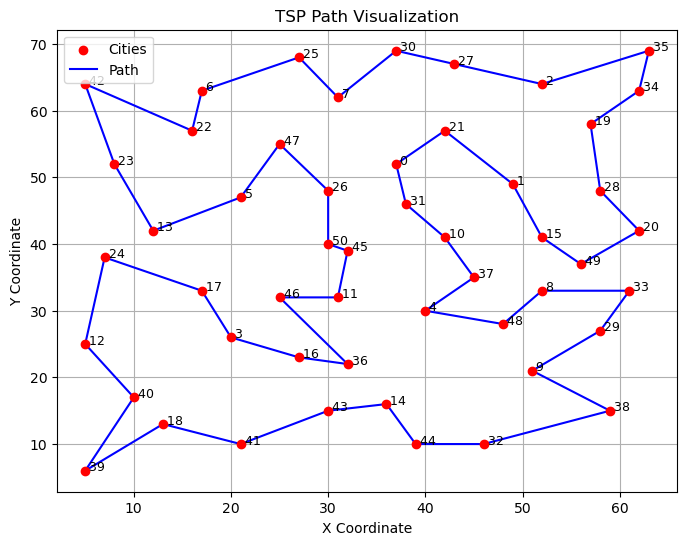

In [19]:

def plot_tsp_path(cities, route):
    """
    Plot the cities and the path connecting them.
    
    Args:
        cities: A list of tuples representing the coordinates of cities (e.g., [(x1, y1), (x2, y2), ...]).
        route: A list of indices representing the order in which cities are visited.
    """
    # Extract coordinates in the order of the route
    x_coords = [cities[i][0] for i in route] + [cities[route[0]][0]]
    y_coords = [cities[i][1] for i in route] + [cities[route[0]][1]]
    
    # Plot cities
    plt.figure(figsize=(8, 6))
    plt.scatter(*zip(*cities), color='red', label='Cities', zorder=3)
    for idx, (x, y) in enumerate(cities):
        plt.text(x, y, f' {idx}', fontsize=9, zorder=4)
    
    # Plot the path
    plt.plot(x_coords, y_coords, color='blue', linestyle='-', linewidth=1.5, label='Path', zorder=2)
    
    # Add details
    plt.title("TSP Path Visualization")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_tsp_path(coord, best_solution)

In [22]:
# Parameters
initial_temp = np.linspace(100, 10000, 20)
cost_temp = []
sol_temp = []
cooling_rate = 0.995
max_iter = 10000
markov_length = 100


for temp in initial_temp:
    best_solution, best_cost = simulated_annealing(dist_matrix, temp, cooling_rate, max_iter, markov_length)
    sol_temp.append(best_solution)
    cost_temp.append(best_cost)



KeyboardInterrupt: 